# Surviving the Titanic
The problem is to use machine learning algorithms to create a model to predict which passengers survived and which perished in the Titanic disaster.  

The data set is from https://www.kaggle.com/c/titanic. It consists of training data set and a testing dataset. Both are csv files. Using the below code I read in the data from each file into a dataframe in python. I used the dtype argument to specify that the Age column should be set to type float64. I was then able to call the .info() method on each to bring back information on the data sets.

In [28]:
# Imports
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt

# import seaborn by "pip install seaborn" 
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# import machine learning libraries
from sklearn import cross_validation
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("test.csv", dtype={"Age": np.float64}, )

In [29]:
# preview the data
print titanic_df.head()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
# print details
titanic_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

There are missing values for Age, Cabin and Embarked in the training dataset e.g. the column Age has 714 entries out of a possible 891. The training dataset has missing values for Age and Cabin and 1 missing value for fare.  

The ticket column is just the ticket number. It is not likely to be useful in analysis or prediction so I am going to drop it in both the training and test datasets.

In [30]:
# drop the ticket columns in each, it is just a ticket number so is unlikely to be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId','Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

## Title ##
There is a title associated with the names. This could be important so I decided to create a new column for Title and print out the findings.

In [31]:
# TITLE
# Create new title column and get title by splitting the passenger name column
titanic_df['Title'] = titanic_df['Name'].apply(lambda x: x.split(',')[1].strip().split('.')[0])
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].strip().split('.')[0])
titanic_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Title, dtype: int64

Mlle and Mme are just a translation of Miss and Mrs so it makes sense to just change these to match the English version. I also changed Ms to Miss. I decided it would be interesting to see if being a Dr or Rev or having a military title would have had any impact on your survival chances so I left Dr and Rev as is and changed Col, Major and Capt to “Military Title”. The other titles have very few people so I combined them into one group and changed them all to “Rare Title”. I then plotted survival against Title to get the below barchart.

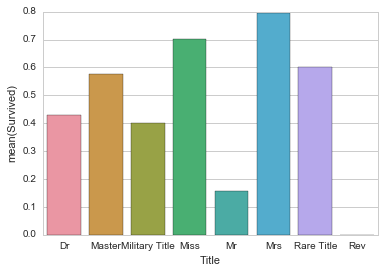

In [32]:
# In titanic_df change Mlle and Ms to Miss, Mme to Mrs. Changed Col, Major and Capt to Military Title and all others to Rare Title
titanic_df['Title'] = np.where(titanic_df['Title'].isin(['Mlle', 'Ms']), 'Miss', titanic_df['Title'])
titanic_df['Title'] = np.where(titanic_df['Title'].isin(['Mme']), 'Mrs', titanic_df['Title'])
titanic_df['Title'] = np.where(titanic_df['Title'].isin(['Major', 'Col', 'Capt']), 'Military Title', titanic_df['Title'])
titanic_df['Title'] = np.where(titanic_df['Title'].isin(['Jonkheer', 'Lady', 'Don', 'Dona', 'the Countess', 'Sir']), 'Rare Title', titanic_df['Title'])

# Plot Title vs Survived
title_perc = titanic_df[['Title', 'Survived']].groupby(['Title'], as_index = False).mean()
sns.barplot(x = 'Title', y = 'Survived', data = title_perc)


This shows that Mrs and Miss were the most likely to survive which is what I would expect given that women and children were first into the lifeboats. Next is those with a rare title. Here there are very few records but those with a rare title were more likely to survive than the other titles with small numbers of values. Usually those with one of these rare titles would be wealthy and we have a preconceived notion they would therefore be more likely to survive. A better way to look at this will be examining the Pclass. Those with the title Rev all perished.   

The sklearn package in Python needs all variables input as numbers. Title is categorical so I need to create dummy variables to deal with this. The pandas method get_dummies() will create the correct number of dummy variables when given a variable as an argument. For title it creates a new variable with names as above. Each record is given a 1 or 0 in each variable depending on its value in Title.   

I then dropped the name and title variables from the data frame as the data I plan to use is now in the new variables Dr, Master, Military Title, Miss, Mr, Mrs, Rare Title and Rev. 

In [33]:
# Make the same changes in test_df
test_df['Title'] = np.where(test_df['Title'].isin(['Mlle', 'Ms']), 'Miss', test_df['Title'])
test_df['Title'] = np.where(test_df['Title'].isin(['Mme']), 'Mrs', test_df['Title'])
test_df['Title'] = np.where(test_df['Title'].isin(['Major', 'Col', 'Capt']), 'Military Title', test_df['Title'])
test_df['Title'] = np.where(test_df['Title'].isin(['Jonkheer', 'Lady', 'Don', 'Dona', 'the Countess', 'Sir']), 'Rare Title', test_df['Title'])

# Need to create dummy variables to handle categorical data for sklearn
title_dummies_titanic = pd.get_dummies(titanic_df['Title'])
title_dummies_test = pd.get_dummies(test_df['Title'])

titanic_df = titanic_df.join(title_dummies_titanic)
test_df = test_df.join(title_dummies_test)

# Drop Name variable and drop Title as the data is contained in new dummy variables
titanic_df = titanic_df.drop(['Name', 'Title'], axis=1)
test_df    = test_df.drop(['Name', 'Title'], axis=1)

## Family ##

As I said above women and children were first to be ordered into the lifeboats. There is information in the data set about whether people had a sibling, spouse, parent or child aboard so I can use this to look at families and see if you were more or less likely to survive if you were part of a family. I created a FamilySize variable made up of SibSp + ParCh + 1. 

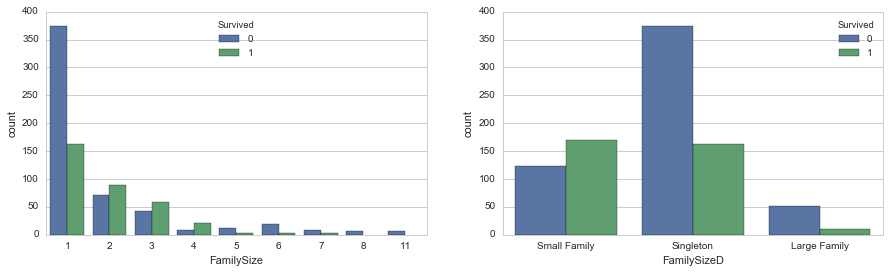

In [34]:
# FAMILY
# Create a family size variable = number parents/children + number siblings/spouses + 1 for the passenger themselves
titanic_df['FamilySize'] =  titanic_df["Parch"] + titanic_df["SibSp"] + 1
test_df['FamilySize'] =  test_df["Parch"] + test_df["SibSp"] + 1

fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))

# Plot the Family size showing number who survived and died
sns.countplot(x = 'FamilySize', hue= 'Survived', data = titanic_df, ax = axis1)

# Create function to be called on the FamilySize column that returns 'singleton', 'small' or 'large' depending on the size of the family
def discrete_family_size(x):
    if x == 1:
        return 'Singleton'
    elif x > 4:
        return 'Large Family'
    else:
        return 'Small Family'

# Apply the function to replace the values of FamilySize with the discretized values 
titanic_df['FamilySizeD'] = titanic_df['FamilySize'].apply(discrete_family_size)        
test_df['FamilySizeD'] = test_df['FamilySize'].apply(discrete_family_size) 
sns.countplot(x = 'FamilySizeD', hue= 'Survived', data = titanic_df, ax = axis2)    

Plotting a count of family sizes compared to the number of people who survived and perished shows that you had a much better chance of surviving if you were in a family of 2, 3 or 4 compared to larger families or those travelling alone. 

I then changed FamilySize to discretized values of FamilySize -  Singleton where FamilySize is 1, Small Family where there are 2 - 4 and Large Family where there are 5 or more in a family. I plotted the graph again on the right using the FamilySize variable and it makes it even clearer which family size had the best survival rate.

I then created dummy variables  Singleton, Small Family and Large Family, so that I can use these in my model, and dropped SibSp, ParCh and FamilySize as these have been taken into account in the dummy variables

In [35]:
# Create dummy variables for FamilySize
fsized_dummies_titanic = pd.get_dummies(titanic_df['FamilySizeD'])
fsized_dummies_test = pd.get_dummies(test_df['FamilySizeD'])

titanic_df = titanic_df.join(fsized_dummies_titanic)
test_df = test_df.join(fsized_dummies_test)

# Drop SibSp, ParCh, FamilySize as the information is contained in new dummy variables Singleton, Small and Large
titanic_df = titanic_df.drop(['SibSp','Parch', 'FamilySize', 'FamilySizeD'], axis=1)
test_df    = test_df.drop(['SibSp','Parch', 'FamilySize', 'FamilySizeD'], axis=1)

## Missing Variables ##

In the training dataset there are missing values for Age, Cabin and Embarked while in the test data set Age, Cabin and Fare are missing values.

### Embarked ###

There are two missing values in the test set for Embarked. Using the R solution, I found that these people had paid $80. When you look at the others who paid this fare the majority embarked from Cherbourg so it makes sense to set Embarked for both of these to C. I plotted the following graphs. The majority of people left from Southampton but they had the lowest survival rate. Many of those who boarded in Southampton would have been emigrating so they were poor and most likely in third class. We’ll see later that this gave them a low chance of survival.

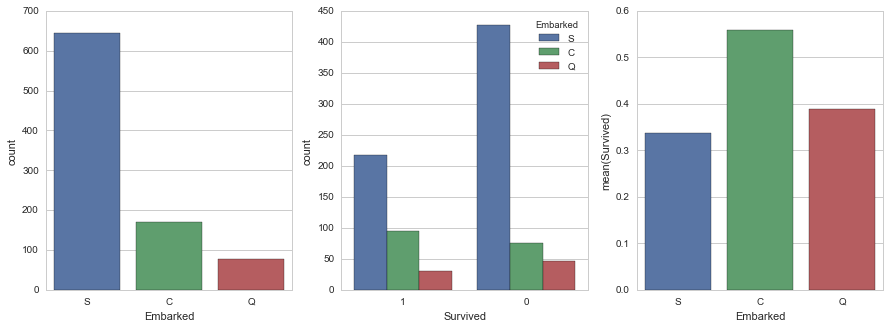

In [36]:
# MISSING VALUES

# EMBARKED
# Fill in the missing values for embarked using the value found as most likely by Megan Risdal's R script 
# where she looked at the fare paid by the people whose Embarked value is missing and looked at the others who paid this
# fare and found that Embarked for the group of people who paid this fare was Cherbourg
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("C")

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
# create countplot showing embarked and another showing survived with different bars for where they embarked
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

In [37]:
# Create dummy variables for C, Q and S
embark_dummies_titanic = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_test = pd.get_dummies(test_df['Embarked'])

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df = test_df.join(embark_dummies_test)

# Dropped Embarked as C, Q and S have been added as dummy variables
titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

### Cabin ###

The cabin field is missing over 800 values between the training and test sets. This is far too many to try to compute. It would also make no sense to try replacing them with other values unless you had a list of all the cabins and could make some sort of sensible imputation based on fare and pclass. As fare and pclass are going to be part of the model then the data from them will already be used. For this model I am dropping Cabin as a variable. 

In [38]:
# CABIN
# There are a huge amount of missing values. It wouldn't make sense to try to fill them in so I am dropping Cabin
titanic_df = titanic_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

### Fare###

In the test data set, test_df, there is a missing value for fare. I replaced this with the median value of fare. I then plotted a histogram of fare and a bar chart of the average fares of those who survived and those who did not. The bar chart includes the standard deviation as the y error.


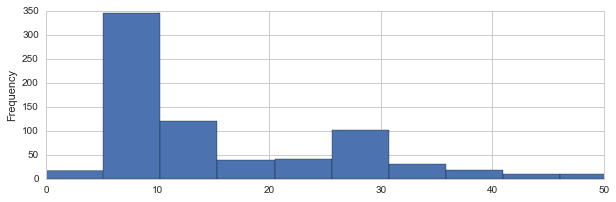

In [39]:
# FARE
# only for test_df, since there is a missing "Fare" values
# Filling in the missing value with the median Fare value
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int 
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot fare as a histogram
fig, axis1 = plt.subplots(1,1,figsize=(10,3))
fig = titanic_df['Fare'].plot(kind = 'hist', figsize=(10,3),bins=100, xlim=(0,50))

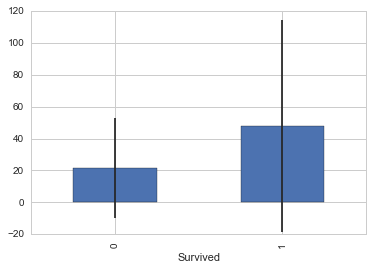

In [40]:
avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare, kind = 'bar', legend = False)

### Age ###

There are 263 missing age values between the training and testing datasets. This is a high number. There are a number of ways of imputing the missing values. I have decided to replace them with random numbers between average age minusstandard deviation and average age plus standard deviation. This should keep the distribution of ages the same. Below are the histograms showing the original age distribution and the new distribution after the random age values have been added. This shows the distribution has not been skewed.

C:\Users\barre\Miniconda2\envs\Siobhan\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\barre\Miniconda2\envs\Siobhan\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


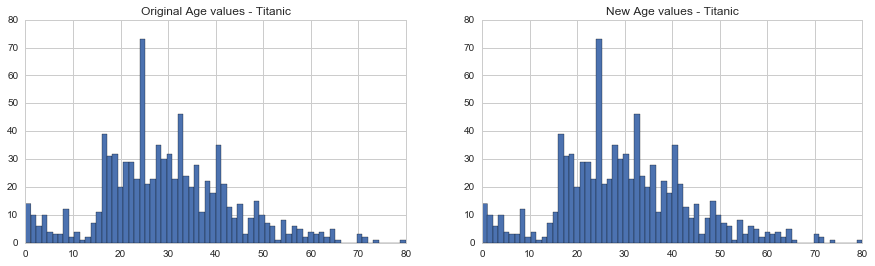

In [41]:
# AGE
# Create new figure with two axes
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum() # take age column give me all those that are null and sum the amount(count the NANs)

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

# plot original Age values
titanic_df['Age'].hist(bins=70, ax=axis1)

# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)

The facet plot below shows survival based on age. The shape of the graphs are similar except survived had a much higher proportion for under 10s and a longer tail at the higher ages. Their peaks are also for different ages.

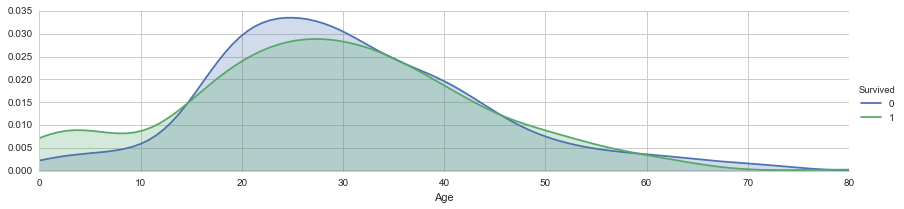

In [42]:
# Looking at average numbers of passengers who survived based on age
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

Plotting a bar chart showing survival rate by age shows you had a much better chance of surviving if you were under 14 or over 48. 

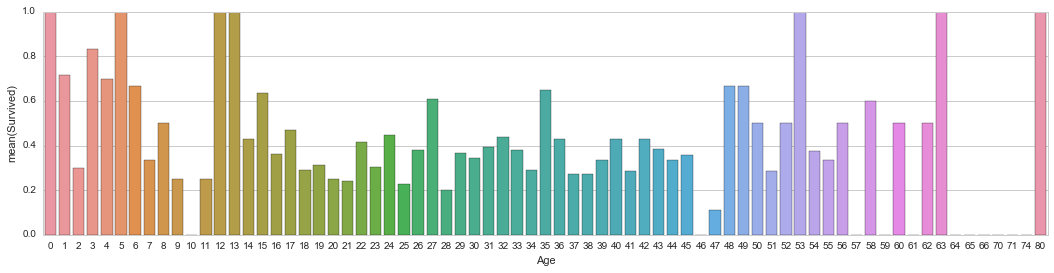

In [43]:
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)
# There was a worse chance of surviving if you were between 14 and 47. Much better chance of surviving if you are over 48 or under 14 e.g.
# every child aged 0, 5, 12 and 13 survived. There may have been just one child aged 0 and they got on to a lifeboat first

## Gender ##
The graph above shows children had a better chance of survival so I created a new classification of a passenger as a child, male or female based on their age and sex. Everyone under 16 is a child and older than that are left at male or female. I plotted each category against count and against survived

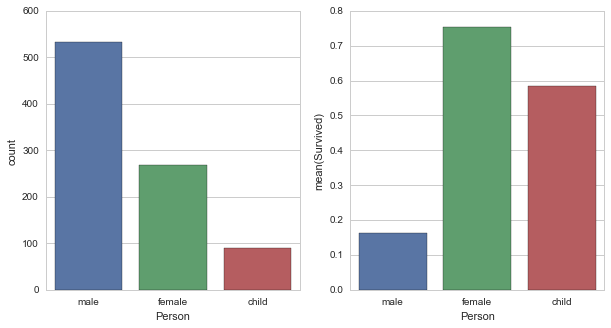

In [44]:
# Gender
# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person'] = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])


As expected this shows women and children had the best chances of survival. I created dummy variables to represent these and dropped person and sex.

In [45]:
# Drop person column
titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

## Passenger Class ##
Plotting passenger class against survived shows that if you were in first class you had the best chance of survival – more than 2.5 times that of third class passengers. Again this is what you would expect to see.

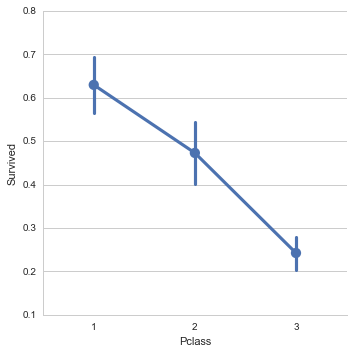

In [46]:
# PCLASS
# First class had a much higher level of survival
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

This is the data exploration and feature engineering sections finished with. Before moving on to modelling I want to check my datasets again to ensure there are no longer any missing values, I have dropped all the columns I intended to and the same columns are in both the test and training files.

In [47]:
#Print information about each
titanic_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
Survived          891 non-null int64
Pclass            891 non-null int64
Age               891 non-null int32
Fare              891 non-null int32
Dr                891 non-null float64
Master            891 non-null float64
Military Title    891 non-null float64
Miss              891 non-null float64
Mr                891 non-null float64
Mrs               891 non-null float64
Rare Title        891 non-null float64
Rev               891 non-null float64
Large Family      891 non-null float64
Singleton         891 non-null float64
Small Family      891 non-null float64
C                 891 non-null float64
Q                 891 non-null float64
S                 891 non-null float64
Child             891 non-null float64
Female            891 non-null float64
Male              891 non-null float64
dtypes: float64(17), int32(2), int64(2)
memory usage: 139.3 KB
<class 'pandas.core.f

## Modelling ##

In order to get ready for using sklearn models I need to define the training and testing datasets. I defined the training set, x-train, to be titanic_df without the Survived column and y_train to be the Survived column.  

I chose to use cross validation. This provides a better way of training the model. Cross validation splits the training set into n equal subsets and then uses n-1 of these to train the model and the unused subset to test on. This process is completed n times with each subset having been the test set exactly once. This gives a more realistic assessment of how a model performs and how it will perform on unseen data. As the training data set is a smaller than best practice proportion of the data, cross validation will help to make the best use of it. I chose a value of 10 for n. 

In [48]:
# DEFINE TRAINING AND TESTING SETS
# X train and Y train are the same except for the removed survived column
x_train = titanic_df.drop("Survived", axis=1) # dropped the survived column
y_train = titanic_df["Survived"] # the answer
x_test  = test_df.drop("PassengerId", axis=1).copy()

In [51]:
# MODELLING

# Logistic Regression
# Score is for the x_train performance against y train
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
lr_score = logreg.score(x_train,y_train)
print 'Logistic Regression Score:', lr_score

Logistic Regression Score: 0.827160493827


In [52]:
# Logistic Regression using Cross Validation using logreg defined above
# accuracy is the prediction compared to Y_Train correct details.
LRPredict = cross_validation.cross_val_predict(logreg, x_train, y_train, cv=10)
print 'Logistic Regression with cross validation accuracy: ', metrics.accuracy_score(y_train, LRPredict) 


Logistic Regression with cross validation accuracy:  0.821548821549


In [53]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
rf_score = random_forest.score(x_train, y_train)
print 'Random Forest score:', rf_score

# Random Forest with Cross Validationusing random_forest defined above
RFPredict = cross_validation.cross_val_predict(random_forest, x_train, y_train, cv=10)
print 'Random Forest with cross validation accuracy: ', metrics.accuracy_score(y_train, RFPredict) 

Random Forest score: 0.967452300786
Random Forest with cross validation accuracy:  0.793490460157


In [54]:
# K Nearest Neighbours
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
knn_score = knn.score(x_train, y_train)
print 'KNN score:', knn_score

# K Nearest Neighbours with Cross Validation using knn defined above
KNNPredict = cross_validation.cross_val_predict(knn, x_train, y_train, cv = 10)
print 'KNN with cross validation:', metrics.accuracy_score(y_train, KNNPredict)

KNN score: 0.836139169473
KNN with cross validation: 0.704826038159


In [55]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
gnb_score = gaussian.score(x_train, y_train)
print 'Gaussian Naive Bayes score:', gnb_score

# Gaussian Naive Bayes with cross validation
GNBPredict = cross_validation.cross_val_predict(gaussian, x_train, y_train, cv = 10)
print 'Gaussian Naive Bayes with cross validation:', metrics.accuracy_score(y_train, GNBPredict)

Gaussian Naive Bayes score: 0.785634118967
Gaussian Naive Bayes with cross validation: 0.773288439955


In [59]:
svc = SVC()
svc.fit(x_train, y_train)
svc_score = svc.score(x_train, y_train)
print 'Support Vector Machine score:', svc_score

# Support Vector Machine using Cross Validation
cvSVC = SVC(kernel='linear', C=1)
SVCPredict = cross_validation.cross_val_predict(cvSVC, x_train, y_train, cv=10)
print 'SVC with cross validation accuracy: ', metrics.accuracy_score(y_train, SVCPredict) 

 Support Vector Machine score: 0.858585858586
SVC with cross validation accuracy:  0.821548821549


## Results ##

I based my program on the kaggle solutions posted by Omar El Gabry and Megan Risdal. I implemented some of Megan’s ideas in the hopes of improving Omar’s program.

My program slightly improves on Omar’s results when cross validation is not used. When I used cross validation all of the scores decreased. As the point of the exercise is to predict who survived in a dataset where the value of survived is unknown I think the cross validated results will give the best indicator of which model is going to give a better prediction on unseen data. Those which have been trained on the whole training data set have learned how to predict values for that dataset very well but the point of creating a model with machine learning is to create a model which generalises well. For this reason, I am going to choose the support vector machine as my best model. Out of all the cross validated models it is the one which has the highest prediction value. The random forest had a score of 96% when no cross validation was used but this fell to 80% indicating to me that this has overfit the data.

## Improvements ##

I think one of the main improvements I could make to my model is to look at the way I imputed missing age values and use a machine learning algorithm to do a more sensible imputation. Python offers a fancyimpute package with a number of algorithms.  

One of the biggest problems when the Titanic disaster happened was issues around getting on to a lifeboat. There simply weren’t enough boats and some of them weren’t usable or not accessible. Delayed boarding was also an issue. A useful variable would be closeness to lifeboat at time of incident. Another could be where did the person die – did they get to the water and drown or were they trapped on the boat. Obviously impractical but would give a more accurate model.  

It would be interesting to take the surname /nationality to see who had a greater chance of survival.  

It would also be interesting to have a crew variable to show who was and was not a member of the crew. The majority of the crew did not survive so I think this would probably be a good indicator. 


## References ##
https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/notebook  
https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/comments   
https://www.kaggle.com/yildirimarda/titanic/titanic-test3/code  
